- Load necessary module

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [29]:
np.random.seed(1)
mat = io.loadmat('temp.mat')
model = {}
model['H'] = mat['H']
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
model['Ns'] = mat['Ns'][0,0] ## need to change nb of stream in channel realization, this case 1
# model['Ns'] = 1
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 2

In [30]:
model['Wopt'].shape

(16, 1, 1000)

In [14]:
# model['H'] = model['H'][:,:,0:2]
# model['Wopt'] = model['Wopt'][:,:,0:2]
# model['Fopt'] = model['Fopt'][:,:,0:2]

In [5]:
for key in model:
    print(key)

H
Ns
Nt
Nr
Nc
Nray
realization
At
Ar
Nrf


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

# Cross Entropy Beamforming

### Helper function for Cross entropy Beamforming

In [8]:
def phase_shifter(n_bit,n_ant):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**n_bit
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i/np.sqrt(n_ant)
    return np.around(ps, decimals=3)

def generate_candidat(S,model,phase_value,ps_system_proba):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    for i in range(S):
        for j in range(model['Nt']):
            for k in range(model['Nrf']):
                F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    return F_rf

def compute_Fbb(F_rf,model,channel):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
#     channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  channel@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
        F_bb[i,:,:] = np.sqrt(model['Ns'])*F_bb[i,:,:]/np.linalg.norm(F_rf[i,:,:]@F_bb[i,:,:],'fro')
    return F_bb

def optimal_beamformer(model, channel):
    """
    Compute the optimal beamformer by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Fopt -- optimal precoder
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    Fopt = np.zeros((model['Nt'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(channel, full_matrices=True)
    V = V.conj().T
    Fopt = V[0:model['Nt'],0:model['Ns']]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Fopt, Wopt


def update_pmf(F_elites,phase_value,nb_elite,R_elite):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    
    Returns:
    ps_system_proba -- pmf of phase shifter
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    assign = np.zeros(nb_elite)
    weight = R_elite/np.mean(R_elite)
    for i in range(model['Nt']):
        for j in range(model['Nrf']):
            for k in range(nb_state):
                assign = F_elites[:,i,j] == phase_value[k]
                proba_est = np.sum(assign*weight)/nb_elite
#                 proba_est = np.sum(assign)/nb_elite
                ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    return ps_system_proba

def data_rate(Ns,SNR,W,H,F):
    """
    Compute the data rate of the beamforming system
    
    Arguments:
    Ns -- number of stream
    SNR -- Signal to noise ratio
    W -- combiner
    H -- channel
    F -- precoder
    
    Returns:
    R -- data rate
    """
    R = np.log2(np.linalg.det(np.eye(Ns)+SNR/Ns*np.linalg.pinv(W)@H@F@F.conj().T@H.conj().T@W))
    return R.real

### Define Phase shiter

In [9]:
nb_bit = 2
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [10]:
phase_value = phase_shifter(nb_bit,model['Nt'])
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [69]:
ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
# print(ps_system_proba)
proba_evo = np.copy(ps_system_proba[0,0,:])
print(proba_evo)

[0.25 0.25 0.25 0.25]


In [73]:
def CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,SNR):
    """
    Hybrid beamforming by Cross-entropy method
    
    """
    Fopt, Wopt = model['Fopt'][:,:,channel_index],model['Wopt'][:,:,channel_index]
    ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
#     proba_evo = np.copy(ps_system_proba[0,0,:])
#     print(proba_evo)
    relative_std = 1000 # initialize high value of relative standard deviation
    i = 0
    while ((i<nb_iterate) and (relative_std>3)):
#         print(i)
        F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
        F_bb = compute_Fbb(F_rf,model,model['H'][:,:,channel_index])
        R = np.zeros((S))
        for j in range(S):
            R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
        R_sort_index = np.argsort(R)[::-1][:nb_elite]
        if i==0:
            R_max = R[R_sort_index[0]]
        else:
            R_max = np.append(R_max,R[R_sort_index[0]])
        F_elites = F_rf[R_sort_index,:,:]
#         Frf_max = F_rf[R_sort_index[0],:,:]
#         Fbb_max = F_bb[R_sort_index[0],:,:]
        ps_system_proba = update_pmf(F_elites,phase_value,nb_elite,R[R_sort_index])
#         proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
        if i>=5:
            R_max_normalize = R_max-np.min(R_max) ## Need to review
            relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
#             print(relative_std)
        i +=1
    output = {}
    output['R_max'] = R_max
#     output['Frf_max'] = Frf_max
#     output['Fbb_max'] = Fbb_max
    output['nb_ite'] = i
#     output['proba_evo'] = proba_evo
    output['ps_system_proba'] = ps_system_proba
    return output

In [31]:
model['H'].shape[2]

1000

In [74]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
# ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
SNR = 10**(10/10)

# CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba,3,SNR)
# data_rate_CE = CE_result['R_max'][-1]
# print(data_rate_CE)
for channel_index in range(10):
    print(channel_index)
    CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,SNR)
    data_rate_CE = CE_result['R_max'][-1]
    print(data_rate_CE)

0
11.5308699314187
1
10.859712950782924
2
11.77423265123264
3
11.277403224415291
4
11.43761122516367
5
11.285764882558512
6
11.101558635428592
7
10.99254957249934
8
11.468978321683899
9
12.029006267286238


In [19]:
np.sum([0.251, 0.295, 0.337, 0.117])

1.0

In [25]:
# Evolution of pmf of 1 phase shifter
np.around(CE_result['proba_evo'], decimals=3)

array([[0.25 , 0.25 , 0.25 , 0.25 ],
       [0.228, 0.316, 0.115, 0.341],
       [0.225, 0.277, 0.128, 0.37 ],
       [0.174, 0.457, 0.125, 0.244],
       [0.178, 0.45 , 0.147, 0.226],
       [0.153, 0.494, 0.196, 0.157],
       [0.06 , 0.612, 0.154, 0.174],
       [0.051, 0.714, 0.106, 0.129],
       [0.051, 0.77 , 0.1  , 0.08 ],
       [0.005, 0.775, 0.054, 0.166],
       [0.001, 0.73 , 0.141, 0.129],
       [0.   , 0.771, 0.149, 0.08 ],
       [0.   , 0.887, 0.083, 0.03 ],
       [0.   , 0.876, 0.098, 0.025],
       [0.   , 0.898, 0.055, 0.048],
       [0.   , 0.945, 0.051, 0.005],
       [0.   , 0.994, 0.005, 0.   ],
       [0.   , 0.999, 0.001, 0.   ],
       [0.   , 1.   , 0.   , 0.   ]])

In [28]:
CE_result['R_max'][-1]

11.508899190982577

Data rate evolution: [ 8.68106353  8.71075617  9.15143393  9.27823675  9.84802042  9.80551032
 10.25738224 10.57110775 10.66439141 11.00275352 11.03321364 11.16671111
 11.22567431 11.34510897 11.34989435 11.42774279 11.45325463 11.50889919]
Number of iteration: 18
Phase shifter pmf[[0.25  0.25  0.25  0.25 ]
 [0.228 0.316 0.115 0.341]
 [0.225 0.277 0.128 0.37 ]
 [0.174 0.457 0.125 0.244]
 [0.178 0.45  0.147 0.226]
 [0.153 0.494 0.196 0.157]
 [0.06  0.612 0.154 0.174]
 [0.051 0.714 0.106 0.129]
 [0.051 0.77  0.1   0.08 ]
 [0.005 0.775 0.054 0.166]
 [0.001 0.73  0.141 0.129]
 [0.    0.771 0.149 0.08 ]
 [0.    0.887 0.083 0.03 ]
 [0.    0.876 0.098 0.025]
 [0.    0.898 0.055 0.048]
 [0.    0.945 0.051 0.005]
 [0.    0.994 0.005 0.   ]
 [0.    0.999 0.001 0.   ]
 [0.    1.    0.    0.   ]]


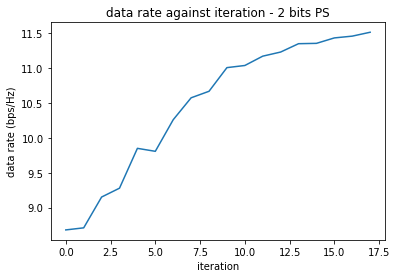

In [26]:
print('Data rate evolution: ' + str(CE_result['R_max']))
plt.plot(CE_result['R_max'])
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')
print('Number of iteration: ' + str(CE_result['nb_ite']))
print('Phase shifter pmf' + str(np.around(CE_result['proba_evo'], decimals=3)))

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate

# Digital Beamforming

In [ ]:
R_o = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],model['Fopt'])
print('Data rate by digital beamforming: ' + str(R_o))

In [ ]:
# Normalize condition
x = np.linalg.norm(CE_result['Frf_max']@CE_result['Fbb_max'],'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

# OMP Beamforming

In [ ]:
def OMP(_Fopt,_NRF,_At):
    """
    Orthogonal matching pursuit for hybrid beamforming
    
    """
    _FRF = np.empty((_At.shape[0],0))
    _Fres = _Fopt
    for k in range(_NRF):
        PU = _At.conj().T@_Fres
        ind = np.argmax(np.sum((np.absolute(PU))**2,axis=1))
        _FRF = np.append(_FRF,_At[:,[ind]],axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
#         _Fres = (_Fopt-_FRF@_FBB)
    return _FRF,_FBB

In [ ]:
FRF_omp, FBB_omp = OMP( model['Fopt'], model['Nrf'], model['At'][:,:,channel_index] ) 

In [ ]:
R_omp = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],FRF_omp@FBB_omp)
print("Data rate by OMP: " + str(R_omp))

### Quantize omp beamforming

In [ ]:
def quantize_Frf(model,n_bit,F_rf,channel_index):
    """
    Quantize precoder for low resolutioin phase shifter
    
    """
    q = 2*np.pi/2**n_bit
    amplitude = 1/np.sqrt(model['Nt'])
    Frf_angle = np.angle(F_rf)
    angle_quantized = q * np.round(Frf_angle/q)
    Frf_quantized = amplitude*np.exp(1j*angle_quantized)
    Frf_quantized = np.around(Frf_quantized, decimals=3)
    
    channel_eq =  model['H'][:,:,channel_index]@Frf_quantized
    U, s, V = np.linalg.svd(channel_eq, full_matrices=True)
    V = V.conj().T
    F_bb = V[0:model['Nt'],0:model['Ns']]
    F_bb = np.sqrt(model['Ns'])*F_bb/np.linalg.norm(Frf_quantized@F_bb,'fro')
    
    return Frf_quantized, F_bb

In [ ]:
Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)

In [ ]:
R_omp_quantized = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],Frf_quantize@Fbb_quantize)
print('Data rate by OMP with quantization: ' + str(R_omp_quantized))

In [ ]:
# Normalize condition
x = np.linalg.norm(Frf_quantize@Fbb_quantize,'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

### Initialize pmf of phase shiter with OMP

In [ ]:
phase_value

In [ ]:
FRF_omp

In [ ]:
Frf_quantize

In [ ]:
def initialize_pmf_omp(model,nb_bit,Frf_omp_quantize,phase_value,ratio):
    """
    Initialize pmf of phase shifter with solution getting by OMP
    
    """
    low_proba = 1/(2**nb_bit-1+ratio)
    high_proba = ratio*low_proba
    proba_init = np.zeros((model['Nt'],model['Nrf'],2**nb_bit))
    for i in range(phase_value.shape[0]):
        assign = Frf_quantize == phase_value[i]
        proba_init[:,:,i] = assign*high_proba + np.invert(assign)*low_proba
    return proba_init

### Cross entropy method with initialization by quantized OMP

In [ ]:
ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
ps_system_proba_omp

In [ ]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
SNR = 10**(10/10)
CE_result_omp = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba_omp,channel_index,SNR)

In [ ]:
print('Data rate evolution: ' + str(CE_result_omp['R_max']))
plt.plot(CE_result_omp['R_max'])
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')
print('Number of iteration: ' + str(CE_result_omp['nb_ite']))
print('Phase shifter pmf' + str(np.around(CE_result_omp['proba_evo'], decimals=3)))

In [ ]:
# print(CE_result_omp['Frf_max'] == CE_result['Frf_max'])
# print(CE_result_omp['Frf_max'] == Frf_quantize)